Settings defined.
Fetching positive sample DOIs from DB...
Found 3,596 positive DOIs used in training.
Loading DOI map from data/processed/pretrained_doi_map.json...
Matched 3,596 positive DOIs to embedding indices.
Sampling 50000 random indices from total 11619136...
Loading embeddings from data/processed/pretrained_scibert_cls_embeddings.npy (memmap read mode)...
File size: 33.24 GB
Calculated vector count: 11,619,136
Extracting vectors for visualization...
Data prepared for UMAP. Shape: (53596, 768)
Running UMAP (this may take a few minutes)...


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plotting...


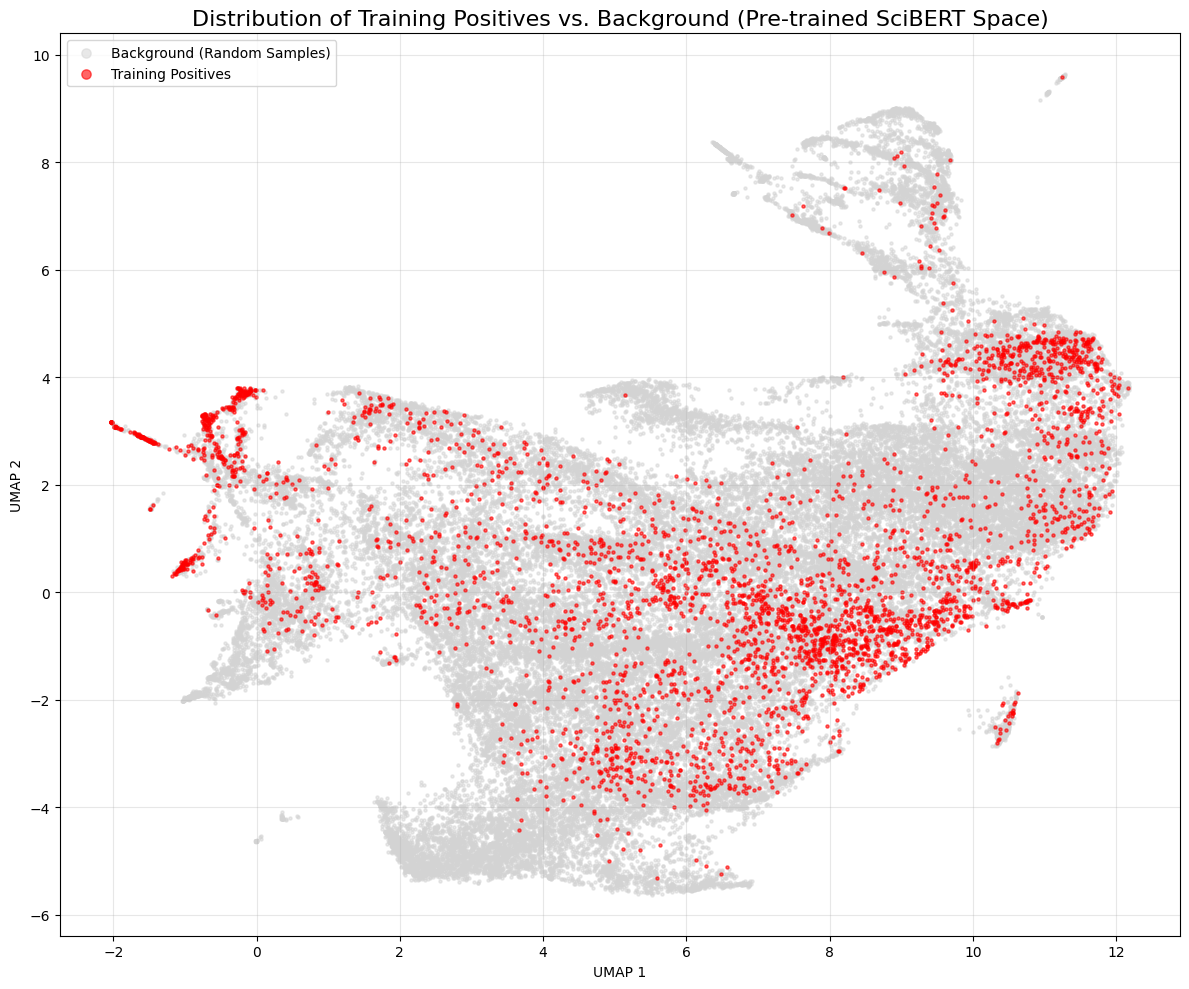

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from tqdm.auto import tqdm

# --- 1. 設定 ---
DB_PATH = "data/processed/s2orc_filtered.db"
DOI_MAP_FILE = "data/processed/pretrained_doi_map.json"
EMBEDDINGS_FILE = "data/processed/pretrained_scibert_cls_embeddings.npy"

# 可視化用にサンプリングする「背景データ（全データ）」の数
NUM_RANDOM_SAMPLES = 50000 

print("Settings defined.")

# --- 2. 正例データのDOIをDBから取得 ---
print("Fetching positive sample DOIs from DB...")
with sqlite3.connect(DB_PATH) as conn:
    # 訓練データに含まれる正例条件: 
    # human_annotation_status = 1 (緑) OR (llm=1 AND human=0) (白)
    query = """
        SELECT citing_doi 
        FROM positive_candidates 
        WHERE human_annotation_status = 1 
           OR (llm_annotation_status = 1 AND human_annotation_status = 0)
    """
    df_positives = pd.read_sql_query(query, conn)

positive_dois = set(df_positives['citing_doi'].values)
print(f"Found {len(positive_dois):,} positive DOIs used in training.")

# --- 3. DOIマップとインデックスの特定 ---
print(f"Loading DOI map from {DOI_MAP_FILE}...")
with open(DOI_MAP_FILE, 'r') as f:
    doi_to_index = json.load(f)

# 正例に対応するインデックスを取得
positive_indices = []
for doi in positive_dois:
    if doi in doi_to_index:
        positive_indices.append(doi_to_index[doi])

print(f"Matched {len(positive_indices):,} positive DOIs to embedding indices.")

# --- 4. ランダムサンプリング (背景データ) ---
print(f"Sampling {NUM_RANDOM_SAMPLES} random indices from total {len(doi_to_index)}...")
all_indices = np.arange(len(doi_to_index))
# 正例以外のインデックスからサンプリング（厳密に分けるため）
available_indices = np.setdiff1d(all_indices, positive_indices)

if len(available_indices) < NUM_RANDOM_SAMPLES:
    random_indices = available_indices
else:
    random_indices = np.random.choice(available_indices, size=NUM_RANDOM_SAMPLES, replace=False)

# --- 5. 埋め込みベクトルの抽出 ---
print(f"Loading embeddings from {EMBEDDINGS_FILE} (memmap read mode)...")

# ファイルサイズからベクトル数（行数）を計算
d = 768 # SciBERTの次元数
file_size = os.path.getsize(EMBEDDINGS_FILE)
dtype_size = np.dtype(np.float32).itemsize # 4バイト
total_vectors = file_size // (d * dtype_size)

print(f"File size: {file_size / (1024**3):.2f} GB")
print(f"Calculated vector count: {total_vectors:,}")

# ▼▼▼ 修正点: np.load ではなく np.memmap を使用 ▼▼▼
embeddings_mmap = np.memmap(
    EMBEDDINGS_FILE,
    dtype=np.float32,
    mode='r',
    shape=(total_vectors, d)
)

print("Extracting vectors for visualization...")
# 正例ベクトル
pos_vectors = embeddings_mmap[positive_indices]
# ランダムベクトル
rand_vectors = embeddings_mmap[random_indices]

# データを結合
X = np.vstack([rand_vectors, pos_vectors])
# ラベル作成 (0: Random/Background, 1: Positive/Training)
y = np.array([0] * len(rand_vectors) + [1] * len(pos_vectors))

print(f"Data prepared for UMAP. Shape: {X.shape}")

# --- 6. UMAPによる次元圧縮 ---
print("Running UMAP (this may take a few minutes)...")
# n_neighbors: 小さいと局所構造、大きいと大域構造を重視 (デフォルト15)
# min_dist: 点の密集度 (デフォルト0.1)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42, n_jobs=-1)
embedding_2d = reducer.fit_transform(X)

# --- 7. 可視化 (散布図) ---
print("Plotting...")
plt.figure(figsize=(12, 10))

# 背景（ランダムデータ）を先にプロット
plt.scatter(
    embedding_2d[y == 0, 0], 
    embedding_2d[y == 0, 1], 
    c='lightgray', 
    s=5, 
    alpha=0.5, 
    label='Background (Random Samples)'
)

# 前景（正例データ）を後にプロット
plt.scatter(
    embedding_2d[y == 1, 0], 
    embedding_2d[y == 1, 1], 
    c='red', 
    s=5, 
    alpha=0.6, 
    label='Training Positives'
)

plt.title('Distribution of Training Positives vs. Background (Pre-trained SciBERT Space)', fontsize=16)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(markerscale=3) # 凡例の点を大きく表示
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()